In [1]:
import fenics as f
import matplotlib.pyplot as plt
from models import velocity_field, transient_t_transport_sim, mesh_2d, t_transport_sim
import numpy as np
import scipy

----------  Running for dT=5 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00


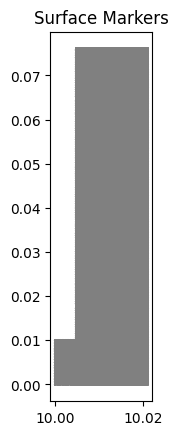

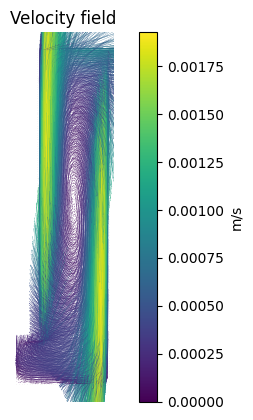

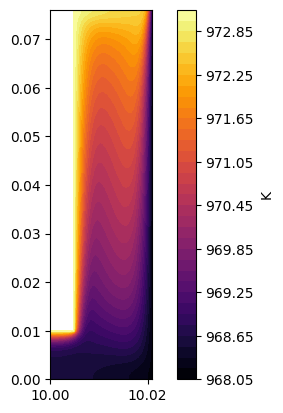

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        6.0e+05 s    Ellapsed time so far: 7.0 s


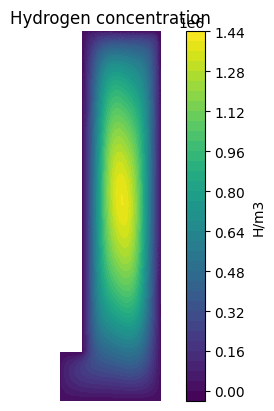

[3.56025099e+03 6.19793708e+03 8.48340161e+03 1.06081056e+04
 1.26524969e+04 1.46583798e+04 1.66499090e+04 1.86420608e+04
 2.06452097e+04 2.26674041e+04 2.47153835e+04 2.67950552e+04
 2.89117487e+04 3.10703602e+04 3.32754351e+04 3.55312084e+04
 3.78416198e+04 4.02103085e+04 4.26405957e+04 4.51354541e+04
 4.76974652e+04 5.03287652e+04 5.30309741e+04 5.58051083e+04
 5.86514713e+04 6.15695174e+04 6.45576837e+04 6.76131839e+04
 7.07317609e+04 7.39073972e+04 7.71319941e+04 8.03950377e+04
 8.36832879e+04 8.69805375e+04 9.02674984e+04 9.35218732e+04
 9.67186651e+04 9.98307566e+04 1.02829765e+05 7.23428623e+04
 5.68427837e+04 4.58580942e+04 3.71547914e+04 2.99292985e+04
 2.38274172e+04 1.86715121e+04 6.05910789e+04 8.00078074e+04
 9.28178419e+04 1.02096026e+05 1.08952908e+05 5.67573834e+04
 3.46209626e+04 2.13848336e+04 1.29422117e+04 7.58245386e+03
 4.27553601e+03 2.31204330e+03 1.19572064e+03 5.89968522e+02
 2.77064083e+02 1.23564127e+02 5.22141194e+01 2.08594883e+01
 7.86127658e+00 2.788880

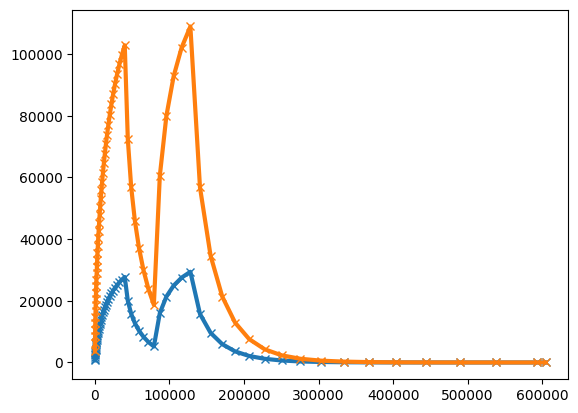

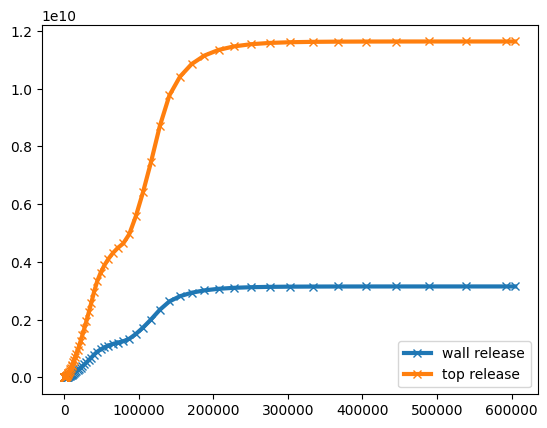

In [3]:
# Generating mesh
# x1 = 0.00476
# x2 = 0.0162
# y1 = 0.01
# y2 = 0.0761
# resolution = 30
# mesh_fenics, surface_markers, left_id, top_id, right_id, bottom_id, upper_left_id, left_top_id = LMeshmshr(x1, x2, y1, y2, resolution)

mesh_fenics, volume_markers, surface_markers, correspondance_dict = mesh_2d()

T_hot = 700 + 273.15
dT = 5
T_cold = T_hot - dT

print(f"----------  Running for dT={dT} K  ----------")
foldername = f"Results_Transient/dt={dT}/"
u, p, T = velocity_field(
    T_cold=T_cold,
    T_hot=T_hot,
    my_mesh=mesh_fenics,
    surface_markers=surface_markers,
    correspondance_dict=correspondance_dict,
)

f.XDMFFile(foldername + "temperature_field.xdmf").write_checkpoint(
    T, "temperature", 1, f.XDMFFile.Encoding.HDF5
)
f.XDMFFile(foldername + "velocity_field.xdmf").write(u)

plt.figure()
plt.title("Velocity field")
CS = f.plot(u, scale=1e-3)
plt.colorbar(CS, label="m/s")
plt.axis("off")
plt.show()

plt.figure()
TS = f.plot(T, cmap="inferno")
plt.colorbar(TS, label="K")
plt.show()

top_flux, wall_flux, t = transient_t_transport_sim(
    T,
    mesh_fenics,
    u,
    volume_markers=volume_markers,
    surface_markers=surface_markers,
    correspondance_dict=correspondance_dict,
)

plt.figure()
plt.plot(t, wall_flux, "-x", linewidth=3)
plt.plot(t, top_flux, "-x", linewidth=3)

wall_release = scipy.integrate.cumulative_trapezoid(wall_flux, t, initial=0)
top_release = scipy.integrate.cumulative_trapezoid(top_flux, t, initial=0)

plt.figure()
plt.plot(t, wall_release, "-x", linewidth=3, label="wall release")
plt.plot(t, top_release, "-x", linewidth=3, label="top release")
plt.legend()
plt.show()